**Welcome to the example robot agent Colab from Mbodi!**

This colab demonstrate how to use mbodied-agents for a simple intelligent robot agent and output actions based on the observation and human instruction.

This is a copy of https://github.com/MbodiAI/mbodied-agents/blob/main/examples/simple_robot_agent.py




## Clone the repo



In [1]:
!git clone https://github.com/MbodiAI/mbodied-agents.git
%cd mbodied-agents
!pip install -e .

fatal: destination path 'mbodied-agents' already exists and is not an empty directory.
/content/mbodied-agents
Obtaining file:///content/mbodied-agents
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mbodied (pyproject.toml) ... done
  Created wheel for mbodied: filename=mbodied-0.0.1-py3-none-any.whl size=7843 sha256=2d722e67f37acc9cefe707ad1289150382cdcc132e2bc645ea1d1c56863d3d25
  Stored in directory: /tmp/pip-ephem-wheel-cache-qupt61xz/wheels/06/af/48/8c3854a4c8663a1fff05be743fdc8a2e2876d133ecb4743dae
Successfully built mbodied


## Install dependencies

In [2]:
!pip install coverage[toml]
!pip install toml
!pip install gym
!pip install pillow
!pip install numpy
!pip install opencv-python
!pip install anthropic
!pip install openai
!pip install backoff
!pip install pydantic
!pip install pydantic_numpy
!pip install torch
!pip install h5py
!pip install datasets
!pip install art
!pip install jsonref

## Import all neccessary packages

Note that we are not importing the audio handler here in the Colab. We are going to use keyboard and screen for IO.

In [3]:
import os
import logging

import click
from pydantic import Field
from pydantic_core import from_json
from gym import spaces

import sys
sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), 'src'))

from mbodied.agents.language import CognitiveAgent
# For this colab example, we are not using audio IO.
# from mbodied.agents.sense.audio_handler import AudioHandler
from mbodied.base.sample import Sample
from mbodied.hardware.sim_interface import SimInterface
from mbodied.types.controls import HandControl
from mbodied.types.vision import Image
from mbodied.data.recording import Recorder

## Define a Sample for your robot agent's output.

This can be customized to be anything you like. In this example, we have an answer field, which is what the robot speaks to you, and a list of hand controls (X,Y,Z,R,P,Y) which is the end effector delta for robot's hand.

In [4]:
class AnswerAndActionsList(Sample):
    """A customized pydantic type for robot's reply and actions."""
    answer: str | None = Field(
        default="",
        description="Short, one sentence answer to user's question or request.",
    )
    actions: list[HandControl] | None = Field(
        default=[],
        description="List of actions to be taken by the robot.",
    )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Initialized the Cognitive Agent

Cognitive Agent is the entry point for your intelligent robot. It's responsible of handling the planning, reasoning, or action output. You may even have multiple Cognitive Agent in parallel handling different aspect for your robot, i.e. planning, motion control, sensory, etc.

For the simplest example, we can use OpenAI's GPT for the cognitive Agent here. Anthropic is also supported here.

Mbodi's backend and HuggingFace backend is also upcoming.

The system prompt is minimal. You can provide more context if you like.

In [5]:
openai_api_key = "PLEASE TYPE YOUR OPENAI API KEY HERE"

SYSTEM_PROMPT = f"""
    You are robot with vision capabilities.
    For each task given, you respond in JSON format. Here's the JSON schema:
    {AnswerAndActionsList.model_json_schema()}
    """

robot_agent = CognitiveAgent(context=SYSTEM_PROMPT, api_service="openai", api_key=openai_api_key)

# No audio for this Colab
# audio = AudioHandler(use_pyaudio=False)

Welcome to
 __  __  _                 _  _ 
|  \/  || |__    ___    __| |(_)
| |\/| || '_ \  / _ \  / _` || |
| |  | || |_) || (_) || (_| || |
|_|  |_||_.__/  \___/  \__,_||_|
                                

A platform for intelligent embodied agents.


Initializing cognitive agent for robot using backend: openai


## Initialize Robot Hardware Interface

We are using a mock robot interface for movement visualization here. It only prints out the action.

In [6]:
robot_interface = SimInterface()

## Define data Recorder

Initialize data recorder for every conversation and every action.
A new dataset is created each time you interact, teach or train the robot.
Available for further augmentation finetuning and model training.

Note that we use the gym space here. You can also customize this to be type/format you like.

In [7]:
observation_space = spaces.Dict({
    'image': Image(size=(224, 224)).space(),
    'instruction': spaces.Text(1000)
})
action_space = AnswerAndActionsList(actions=[HandControl()] * 6).space()
recorder = Recorder('example_recorder',
                    out_dir='saved_datasets',
                    observation_space=observation_space,
                    action_space=action_space)


Initializing dataset recorder...
Recording dataset to saved_datasets/example_recorder.h5
To learn more about how to use this dataset, augment the data, train/finetune a foundational model, please go to: https://forms.gle/rv5rovK93dLucma37



/usr/local/lib/python3.10/dist-packages/gym/utils/seeding.py:63: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


Here's the static example for robot's observation for simplicity. To integrate with your robot vision, you'll need to modify the path or subscription inside the while loop below.

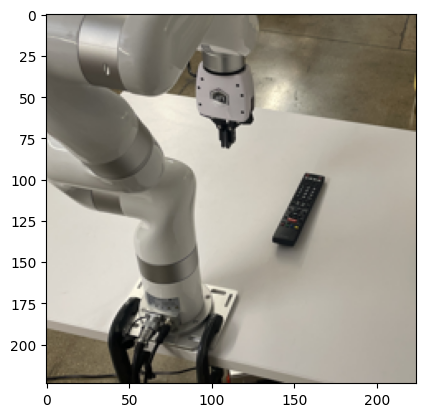

In [8]:
import matplotlib.pyplot as plt
example_image = Image("resources/xarm.jpeg", size=(224, 224)).pil
plt.imshow(example_image)

In [10]:
while True:
    # instruction = audio.listen()
    instruction = input("Please type your instruction: ")
    print("[INSTRUCTION]:", instruction)

    # NOTE: This is just an example vision image.
    # Customize this for your robot's observation.
    image = Image("resources/xarm.jpeg", size=(224, 224))

    response = robot_agent.act(instruction, image)[0]
    response = response.replace("```json", "").replace("```", "")
    print("[RESPONSE]:", response)
    # Validate the response to the pydantic object.
    answer_actions = AnswerAndActionsList.model_validate(from_json(response))

    # Let the robot speak.
    if answer_actions.answer:
        # audio.speak(answer_actions.answer)
        print("Robot is speaking:", answer_actions.answer)

    # Execute the actions with the robot interface.
    if answer_actions.actions:
        for action in answer_actions.actions:
            robot_interface.do(action)

    # Record the dataset for training.
    recorder.record(observation={
        'image': image,
        'instruction': instruction,
    }, action=answer_actions)



Please type your instruction: Hi, how are you?
[INSTRUCTION]: Hi, how are you?
[RESPONSE]: 
{
  "answer": "I'm just a robot, but I'm ready to assist you!",
  "actions": null
}

Robot is speaking: I'm just a robot, but I'm ready to assist you!
Please type your instruction: What do you see on the table?
[INSTRUCTION]: What do you see on the table?
[RESPONSE]: 
{
  "answer": "I see a remote control on the table.",
  "actions": null
}

Robot is speaking: I see a remote control on the table.
Please type your instruction: I'm going to teach you how to pick it up. First move right, and then move down like 0.15.
[INSTRUCTION]: I'm going to teach you how to pick it up. First move right, and then move down like 0.15.
[RESPONSE]: 
{
  "answer": "Moving right and down to position over the remote.",
  "actions": [
    {
      "pose": {
        "x": 0.0,
        "y": 0.15,
        "z": -0.15,
        "roll": 0.0,
        "pitch": 0.0,
        "yaw": 0.0
      },
      "grasp": {
        "value": 1.0

KeyboardInterrupt: Interrupted by user